In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array
import scipy
import os
import cv2

In [2]:
data = pd.read_csv('icml_face_data.csv')
#print(data)
pixel_data = data[' pixels']
label_data = data['emotion']
#print(pixel_data)
#print(label_data)

       emotion        Usage                                             pixels
0            0     Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0     Training  151 150 147 155 148 133 111 140 170 174 182 15...
2            2     Training  231 212 156 164 174 138 161 173 182 200 106 38...
3            4     Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4            6     Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...        ...          ...                                                ...
35882        6  PrivateTest  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883        3  PrivateTest  178 174 172 173 181 188 191 194 196 199 200 20...
35884        0  PrivateTest  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885        3  PrivateTest  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886        2  PrivateTest  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...

[35887 rows x 3 columns]
0        70 80 82 72 58 58

In [3]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)
  X = np.array(images)
  return X

In [4]:
oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

X_over_series = pd.Series(X_over.flatten())
#print(X_over_series)

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    122 116 121 124 131 136 131 132 129 141 150 15...
62919    224 224 223 223 224 220 111 75 81 77 70 46 20 ...
62920    89 81 29 22 26 28 28 26 26 25 33 28 25 31 29 4...
62921    0 6 37 26 16 12 56 125 104 103 102 86 50 83 14...
62922    194 194 194 194 193 195 195 196 198 197 167 14...
Length: 62923, dtype: object


In [5]:
X = preprocess_pixels(X_over_series)
#print(X)
Y = Y_over
Y = Y_over.values.reshape(Y.shape[0],1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 45)

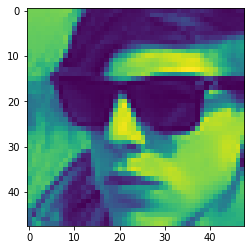

In [6]:
plt.imshow(X[62922,:,:,0])

In [7]:
def emotion_recognition(input_shape):

  X_input = Input(input_shape)

  X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid')(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = MaxPooling2D((2,2))(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

 

  X = MaxPooling2D((2,2))(X)
  X = Flatten()(X)
  X = Dense(200, activation='relu')(X)
  X = Dropout(0.6)(X)
  X = Dense(7, activation = 'softmax')(X)

  model = Model(inputs=X_input, outputs=X)

  return model

In [8]:
model = emotion_recognition((48,48,1))
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
y_train = to_categorical(Y_train, num_classes=7)

y_test = to_categorical(Y_test, num_classes=7)

In [10]:
model.fit(X_train,y_train,epochs=1,validation_data=(X_test,y_test))

1770/1770 [==============================] - 381s 214ms/step - loss: 1.7374 - accuracy: 0.3233 - val_loss: 1.4354 - val_accuracy: 0.4832


In [11]:
preds = model.predict(X_train)
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))

  for i in range(len(preds)):
   pred_class[i] = np.argmax(preds[i])

  return pred_class

pred_class_train = get_class(preds)

1770/1770 [==============================] - 81s 46ms/step


In [12]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}


C:\Users\Charan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


1/1 [==============================] - 0s 205ms/step
The predicted emotion is : Happiness


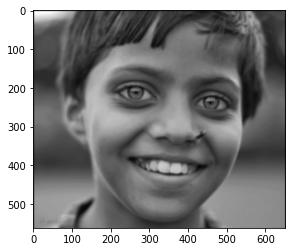

In [13]:
img_path = 'th.jpg'
img = load_img(img_path, grayscale=True, target_size=(48,48))

x = img_to_array(img)
x = np.expand_dims(x, axis=0)

prediction = np.argmax(model.predict(x))
print('The predicted emotion is : ' + label_dict[prediction])
my_image = load_img(img_path)
plt.imshow(my_image)


In [14]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
cap = cv2.VideoCapture(0)

while True:
 
 _,cap_image = cap.read()

 cap_img_gray = cv2.cvtColor(cap_image, cv2.COLOR_BGR2GRAY)

 faces = face_haar_cascade.detectMultiScale(cap_img_gray, 1.3, 5)

 for (x,y,w,h) in faces:

   cv2.rectangle(cap_image, (x,y), (x+w,y+h),(255,0,0),2)
   roi_gray = cap_img_gray[y:y+h, x:x+w]
   roi_gray = cv2.resize(roi_gray, (48,48))
   img_pixels = img_to_array(roi_gray)
   img_pixels = np.expand_dims(img_pixels, axis=0)

   predictions = model.predict(img_pixels)
   emotion_label = np.argmax(predictions)

   emotion_prediction = label_dict[emotion_label]

   cv2.putText(cap_image, emotion_prediction, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1 )

   resize_image = cv2.resize(cap_image, (1000,700))
   cv2.imshow('Emotion',resize_image)

   if cv2.waitKey(1)==27:
        break
  
cap.release()
cv2.destroyAllWindows

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 30ms/step
